<span style="font-size: 32px;">**Импорт библиотек**</span></span>

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from collections import Counter
from datetime import datetime
import warnings
from typing import Tuple, Dict, Any
from tabulate import tabulate
from matplotlib.patches import Patch

<span style="font-size: 32px;">**Настройка параметров**</span></span>

In [66]:
class Config:
    MODEL_PATH = 'rain_predictor_final.joblib'
    TRAIN_DATA_PATH = 'train_df.csv'
    RANDOM_STATE = 42
    TEST_SIZE = 0.2
    TOP_CITIES = 10
    PRECISION_WEIGHT = 1.5
    HUMIDITY_THRESHOLD = 75
    CLOUD_THRESHOLD = 60
    RAINFALL_THRESHOLD = 0.5
    INITIAL_THRESHOLD = 0.35
    REQUIRED_COLUMNS = [
        'Date', 'Location', 'RainToday', 'RainTomorrow', 
        'MaxTemp', 'MinTemp', 'Humidity3pm', 'Humidity9am',
        'Cloud9am', 'Cloud3pm', 'Rainfall'
    ]

# Отключение предупреждений
warnings.filterwarnings('ignore', category=RuntimeWarning)

<span style="font-size: 32px;">**Проверка наличия колонок**</span></span>

In [67]:
def check_required_columns(df: pd.DataFrame) -> None:
    missing = set(Config.REQUIRED_COLUMNS) - set(df.columns)
    if missing:
        raise ValueError(f"Отсутствуют обязательные колонки: {missing}\n"
                       f"Найдены колонки: {list(df.columns)}")

<span style="font-size: 32px;">**Вычисление агрегатных функций**</span></span>

In [68]:
def safe_aggregate(x: pd.Series, func: str = 'max') -> float:
    """Безопасное вычисление агрегатных функций"""
    valid_values = x.dropna()
    if not valid_values.empty:
        return getattr(valid_values, func)()
    return np.nan

<span style="font-size: 32px;">**Предварительная обработка данных и Создание признаков**</span></span>

In [69]:
def preprocess_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, list, list]:
    check_required_columns(df)
    df = df.copy()
    
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.sort_values('Date').reset_index(drop=True)
    
    # Преобразование целевых переменных
    target_mapping = {'Yes': 1, 'No': 0, np.nan: 0}
    for col in ['RainToday', 'RainTomorrow']:
        if col in df.columns:
            df[col] = df[col].map(target_mapping)
    
    # Заполнение пропусков
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c not in ['RainTomorrow', 'RainToday']]
    
    categorical_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location']
    categorical_cols = [c for c in categorical_cols if c in df.columns]
    
    for col in numeric_cols:
        df[col] = df[col].fillna(safe_aggregate(df[col], 'median') or 0)
    
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown')
    
    # Создание признаков
    df = create_features(df)
    
    return df, numeric_cols, categorical_cols

def create_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    if all(col in df.columns for col in ['MaxTemp', 'MinTemp']):
        df['TempDiff'] = df['MaxTemp'] - df['MinTemp']
   
    if all(col in df.columns for col in ['Humidity3pm', 'Humidity9am']):
        df['HumidityChange'] = df['Humidity3pm'] - df['Humidity9am']
    
    cloud_cols = [c for c in ['Cloud9am', 'Cloud3pm'] if c in df.columns]
    if cloud_cols:
        df['CloudCover'] = df[cloud_cols].max(axis=1)
    
    if 'Date' in df.columns:
        df['Month'] = df['Date'].dt.month
        df['Season'] = (df['Month'] % 12 + 3) // 3
    
    if 'Rainfall' in df.columns:
        for days in [3, 7]:
            col_name = f'RainLast{days}Days'
            try:
                if 'Location' in df.columns:
                    df[col_name] = df.groupby('Location')['Rainfall'].transform(
                        lambda x: x.rolling(days, min_periods=1).sum().fillna(0))
                else:
                    df[col_name] = df['Rainfall'].rolling(days, min_periods=1).sum().fillna(0)
            except Exception:
                df[col_name] = 0.0
    
    # Заполнение пропусков после создания признаков
    numeric_cols = df.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].median() if df[col].notna().any() else 0)
    
    return df

<span style="font-size: 32px;">**Создание пайплана и модели**</span></span>

In [70]:
def create_model_pipeline(numeric_features: list, categorical_features: list, y_train: pd.Series) -> Pipeline:
    class_counts = Counter(y_train)
    scale_pos_weight = (class_counts[0] / class_counts[1]) * 3.0 if class_counts[1] > 0 else 1.0
    
    print("\nРаспределение классов:")
    print(f"Без дождя (0): {class_counts[0]} ({class_counts[0]/len(y_train):.1%})")
    print(f"Дождь (1): {class_counts[1]} ({class_counts[1]/len(y_train):.1%})")
    print(f"Коэффициент масштабирования: {scale_pos_weight:.2f}")
    
    
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))])
    
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    
    
    base_model = XGBClassifier(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=Config.RANDOM_STATE,
        scale_pos_weight=scale_pos_weight,
        eval_metric='aucpr',
        reg_alpha=0.2,
        reg_lambda=1.0
    )
    
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selector', SelectFromModel(
            RandomForestClassifier(n_estimators=50, random_state=Config.RANDOM_STATE),
            threshold='median')),
        ('classifier', CalibratedClassifierCV(
            base_model,
            method='isotonic',
            cv=TimeSeriesSplit(n_splits=3)
        ))
    ])
    
    return model


<span style="font-size: 32px;">**Поиск оптимального порога**</span></span>

In [71]:
def find_optimal_threshold(y_true: np.ndarray, y_probs: np.ndarray) -> float:
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    scores = (Config.PRECISION_WEIGHT * precision + recall) / (Config.PRECISION_WEIGHT + 1)
    return thresholds[np.argmax(scores)]

<span style="font-size: 32px;">**"Безопасное" предсказание**</span></span>

In [72]:
def safe_predict(model: Pipeline, X: pd.DataFrame) -> np.ndarray:
    X = create_features(X)
    required_cols = ['Humidity3pm', 'CloudCover', 'RainLast3Days', 'Season']
    for col in required_cols:
        if col not in X.columns:
            X[col] = 0
    try:
        return model.predict_proba(X)[:, 1]
    except Exception:
        return np.zeros(len(X))

<span style="font-size: 32px;">**Предсказание с бизнес-правилами** </span></span>

In [73]:
def predict_with_rules(model: Pipeline, X: pd.DataFrame, threshold: float = Config.INITIAL_THRESHOLD) -> Tuple[np.ndarray, np.ndarray]:
    probs = safe_predict(model, X)
    
    # признаки как numpy массивы
    humidity = X['Humidity3pm'].to_numpy() if 'Humidity3pm' in X.columns else np.zeros(len(X))
    cloud = X['CloudCover'].to_numpy() if 'CloudCover' in X.columns else np.zeros(len(X))
    rainfall = X['RainLast3Days'].to_numpy() if 'RainLast3Days' in X.columns else np.zeros(len(X))
    season = X['Season'].to_numpy() if 'Season' in X.columns else np.ones(len(X))
    
    # применение условий к массивам numpy
    condition1 = (probs >= threshold)
    condition2 = (humidity >= Config.HUMIDITY_THRESHOLD)
    condition3 = (cloud >= Config.CLOUD_THRESHOLD)
    condition4 = (rainfall > Config.RAINFALL_THRESHOLD)
    condition5 = ((season == 1) & (humidity >= 65))
    
    combined_condition = condition1 & (condition2 | condition3 | condition4 | condition5)
    predictions = np.where(combined_condition, 1, 0)
    
    return predictions, probs

<span style="font-size: 32px;">**Вывод метрик** </span></span>

In [74]:
def print_metrics(y_true: np.ndarray, y_pred: np.ndarray, title: str) -> dict:
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    print(f"\n{title}")
    print(f"Точность (Accuracy): {report['accuracy']:.3f}")
    print("┌────────┬───────────┬──────────┬─────────┐")
    print("│ Класс  │ Точность  │ Полнота  │ F1-мера │")
    print("├────────┼───────────┼──────────┼─────────┤")
    for cls in ['0', '1']:
        print(f"│ {cls:6} │ {report[cls]['precision']:9.3f} │ {report[cls]['recall']:8.3f} │ {report[cls]['f1-score']:7.3f} │")
    print("└────────┴───────────┴──────────┴─────────┘")
    
    return report

<span style="font-size: 32px;">**Оценка модели** </span></span>

In [75]:
def evaluate_model(model: Pipeline, X: pd.DataFrame, y: pd.Series, threshold: float, dataset_name: str) -> Dict[str, Any]:
    """Оценка модели с визуализацией"""
    # Стандартные предсказания
    y_prob = safe_predict(model, X)
    y_pred = (y_prob >= threshold).astype(int)
    
    # С бизнес-правилами
    y_pred_rules, _ = predict_with_rules(model, X, threshold)
    
    # Вывод метрик
    print(f"\n{'='*50}")
    print(f"ОЦЕНКА МОДЕЛИ: {dataset_name.upper()}")
    print(f"Оптимальный порог: {threshold:.4f}")
    
    std_report = print_metrics(y, y_pred, "Стандартные предсказания")
    rules_report = print_metrics(y, y_pred_rules, "Предсказания с правилами")
    
    # Визуализация матриц ошибок
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    for i, (pred, title) in enumerate(zip(
        [y_pred, y_pred_rules],
        ['Стандартные предсказания', 'С бизнес-правилами']
    )):
        ConfusionMatrixDisplay.from_predictions(
            y, pred, ax=ax[i], cmap='Blues',
            display_labels=['Нет дождя', 'Дождь'],
            colorbar=False, text_kw={'fontsize': 12})
        ax[i].set_title(title, pad=15, fontsize=12)
        ax[i].set_xlabel('Предсказанный класс', fontsize=10)
        ax[i].set_ylabel('Истинный класс', fontsize=10)
    
    plt.suptitle(f"Матрицы ошибок для {dataset_name}", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return {
        'standard': std_report,
        'with_rules': rules_report
    }

<span style="font-size: 32px;">**Обучение модели** </span></span>

In [76]:
def train_and_evaluate() -> Tuple[Pipeline, float, Dict[str, Any]]:
    print("="*50)
    print("ОБУЧЕНИЕ МОДЕЛИ".center(50))
    print("="*50)
    
    try:
        print("\nЗагрузка и подготовка данных...")
        data = pd.read_csv(Config.TRAIN_DATA_PATH)
        data, numeric_features, categorical_features = preprocess_data(data)
        
        test_size = int(len(data) * Config.TEST_SIZE)
        train_data = data.iloc[:-test_size]
        test_data = data.iloc[-test_size:]
        
        X_train = train_data.drop('RainTomorrow', axis=1)
        y_train = train_data['RainTomorrow']
        X_test = test_data.drop('RainTomorrow', axis=1)
        y_test = test_data['RainTomorrow']
        
        X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=Config.RANDOM_STATE, shuffle=False)
        
        print("\nОбучение модели...")
        model = create_model_pipeline(numeric_features, categorical_features, y_train_final)
        model.fit(X_train_final, y_train_final)
        
        y_val_probs = safe_predict(model, X_val)
        optimal_threshold = find_optimal_threshold(y_val, y_val_probs)
        print(f"\nОптимальный порог классификации: {optimal_threshold:.4f}")
        
        print("\nОценка качества модели:")
        metrics = {
            'train': evaluate_model(model, X_train_final, y_train_final, optimal_threshold, "тренировочных данных"),
            'val': evaluate_model(model, X_val, y_val, optimal_threshold, "валидационных данных"),
            'test': evaluate_model(model, X_test, y_test, optimal_threshold, "тестовых данных")
        }
        
        model_data = {
            'model': model,
            'threshold': optimal_threshold,
            'features': numeric_features + categorical_features,
            'metrics': metrics,
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        
        joblib.dump(model_data, Config.MODEL_PATH)
        print(f"\nМодель успешно сохранена в {Config.MODEL_PATH}")
        
        return model, optimal_threshold, metrics
    
    except Exception as e:
        print(f"\nОшибка в процессе обучения: {str(e)}")
        raise

<span style="font-size: 32px;">**Прогноз для городов** </span></span>

In [77]:
def predict_for_cities(model: Pipeline, data: pd.DataFrame, threshold: float = Config.INITIAL_THRESHOLD, top_n: int = Config.TOP_CITIES) -> pd.DataFrame:
    city_data = create_features(data)
    
    if 'Location' in city_data.columns:
        recent_data = city_data.drop_duplicates('Location', keep='last')
    else:
        recent_data = city_data.iloc[[-1]].copy()
    
    results = []
    for _, row in recent_data.iterrows():
        city_row = pd.DataFrame([row])
        pred, prob = predict_with_rules(model, city_row, threshold)
        
        criteria = []
        if 'Humidity3pm' in row and row['Humidity3pm'] >= Config.HUMIDITY_THRESHOLD:
            criteria.append(f"Влажность: {row['Humidity3pm']:.1f}%")
        
        if 'CloudCover' in row and row['CloudCover'] >= Config.CLOUD_THRESHOLD:
            criteria.append(f"Облачность: {row['CloudCover']:.1f}%")
        
        if 'RainLast3Days' in row and row['RainLast3Days'] > Config.RAINFALL_THRESHOLD:
            criteria.append(f"Осадки 3 дня: {row['RainLast3Days']:.1f} мм")
        
        if 'Season' in row and row['Season'] == 1 and 'Humidity3pm' in row and row['Humidity3pm'] >= 65:
            criteria.append(f"Летняя влажность: {row['Humidity3pm']:.1f}%")
        
        results.append({
            'Город': row.get('Location', 'Неизвестно'),
            'Дата': row.get('Date', pd.NaT),
            'Вероятность': float(prob[0]),
            'Прогноз': 'Дождь' if pred[0] == 1 else 'Ясно',
            'Критерии': ", ".join(criteria) if criteria else "Нет значимых факторов"
        })
    
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df = results_df.sort_values('Вероятность', ascending=False).head(top_n)
        results_df['Дата'] = pd.to_datetime(results_df['Дата']).dt.strftime('%d.%m.%Y')
    
    return results_df

# Визуализация прогнозов для городов
def visualize_city_predictions(predictions: pd.DataFrame) -> None:
   
    if predictions.empty:
        print("Нет данных для визуализации")
        return
    
    plt.figure(figsize=(14, 8))
    colors = predictions['Прогноз'].map({'Дождь': '#FF6B6B', 'Ясно': '#4ECDC4'})
    
    bars = plt.barh(
        predictions['Город'], predictions['Вероятность'], 
        color=colors, alpha=0.7, edgecolor='black'
    )
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        info = predictions.iloc[i]['Критерии']
        
        x_pos = width + 0.02 if width < 0.85 else width - 0.1
        ha = 'left' if width < 0.85 else 'right'
        color = 'black' if width < 0.85 else 'white'
        
        plt.text(
            x_pos, bar.get_y() + bar.get_height()/2,
            f"{width:.2f} | {info}",
            va='center', ha=ha, color=color, fontsize=10
        )
    
    plt.xlabel('Вероятность дождя', fontsize=12)
    plt.title(f'Топ-{len(predictions)} городов с прогнозом дождя', fontsize=14, pad=20)
    plt.xlim(0, 1)
    plt.grid(axis='x', alpha=0.3)
    plt.gca().invert_yaxis()
    
    legend_elements = [
        Patch(facecolor='#FF6B6B', edgecolor='black', label='Дождь прогнозируется'),
        Patch(facecolor='#4ECDC4', edgecolor='black', label='Ясная погода')
    ]
    plt.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

#Вывод таблицы прогнозов
def print_city_predictions(predictions: pd.DataFrame) -> None:
    if predictions.empty:
        print("Нет данных для отображения")
        return
    
    print("\nТОП ПРОГНОЗОВ ПОГОДЫ ПО ГОРОДАМ")
    print(tabulate(
        predictions[['Город', 'Дата', 'Вероятность', 'Прогноз', 'Критерии']],
        headers=['Город', 'Дата', 'Вер-ть', 'Прогноз', 'Ключевые факторы'],
        tablefmt='grid',
        stralign='center',
        numalign='center',
        floatfmt=".0%",
        showindex=False
    ))

<span style="font-size: 32px;">**Основная функция выполнения** </span></span>

                 ОБУЧЕНИЕ МОДЕЛИ                  

Загрузка и подготовка данных...

Обучение модели...

Распределение классов:
Без дождя (0): 49149 (77.2%)
Дождь (1): 14553 (22.8%)
Коэффициент масштабирования: 10.13

Оптимальный порог классификации: 0.5822

Оценка качества модели:

ОЦЕНКА МОДЕЛИ: ТРЕНИРОВОЧНЫХ ДАННЫХ
Оптимальный порог: 0.5822

Стандартные предсказания
Точность (Accuracy): 0.857
┌────────┬───────────┬──────────┬─────────┐
│ Класс  │ Точность  │ Полнота  │ F1-мера │
├────────┼───────────┼──────────┼─────────┤
│ 0      │     0.861 │    0.971 │   0.913 │
│ 1      │     0.828 │    0.469 │   0.599 │
└────────┴───────────┴──────────┴─────────┘

Предсказания с правилами
Точность (Accuracy): 0.854
┌────────┬───────────┬──────────┬─────────┐
│ Класс  │ Точность  │ Полнота  │ F1-мера │
├────────┼───────────┼──────────┼─────────┤
│ 0      │     0.858 │    0.973 │   0.912 │
│ 1      │     0.831 │    0.455 │   0.588 │
└────────┴───────────┴──────────┴─────────┘


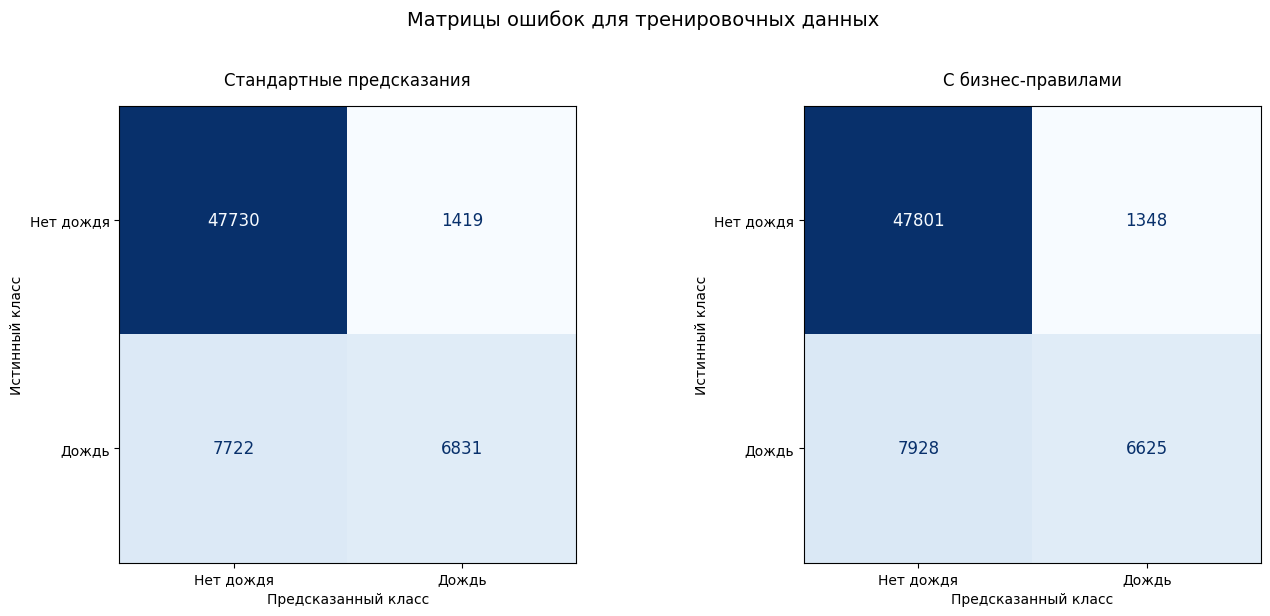


ОЦЕНКА МОДЕЛИ: ВАЛИДАЦИОННЫХ ДАННЫХ
Оптимальный порог: 0.5822

Стандартные предсказания
Точность (Accuracy): 0.849
┌────────┬───────────┬──────────┬─────────┐
│ Класс  │ Точность  │ Полнота  │ F1-мера │
├────────┼───────────┼──────────┼─────────┤
│ 0      │     0.855 │    0.974 │   0.911 │
│ 1      │     0.795 │    0.374 │   0.509 │
└────────┴───────────┴──────────┴─────────┘

Предсказания с правилами
Точность (Accuracy): 0.848
┌────────┬───────────┬──────────┬─────────┐
│ Класс  │ Точность  │ Полнота  │ F1-мера │
├────────┼───────────┼──────────┼─────────┤
│ 0      │     0.853 │    0.975 │   0.910 │
│ 1      │     0.798 │    0.366 │   0.502 │
└────────┴───────────┴──────────┴─────────┘


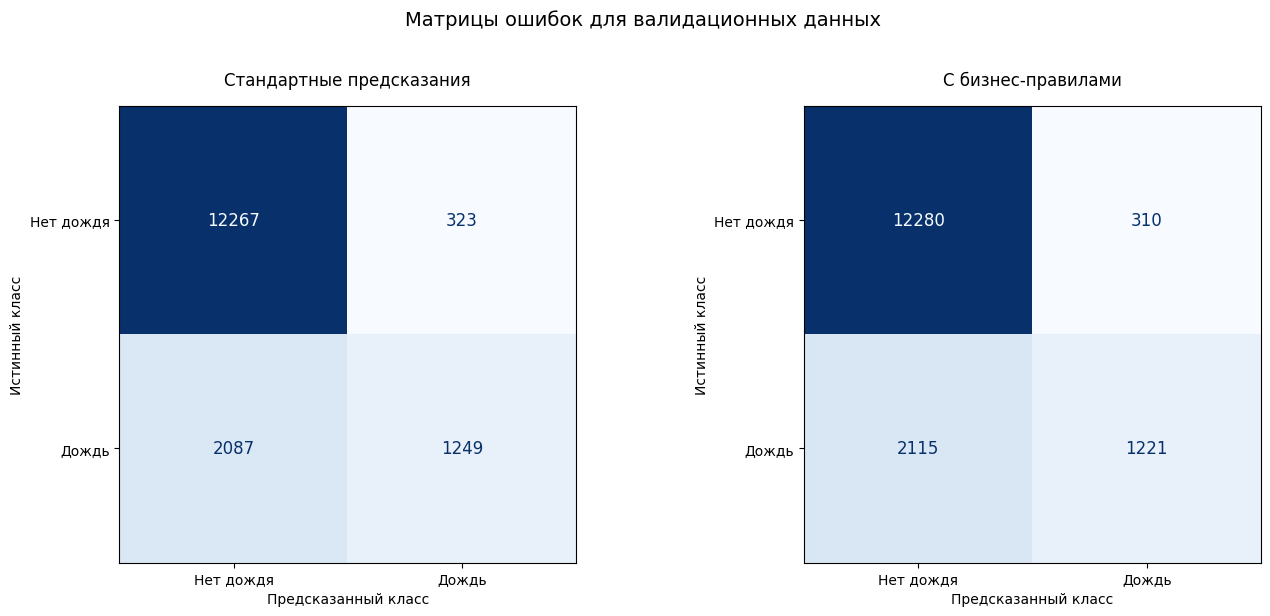


ОЦЕНКА МОДЕЛИ: ТЕСТОВЫХ ДАННЫХ
Оптимальный порог: 0.5822

Стандартные предсказания
Точность (Accuracy): 0.844
┌────────┬───────────┬──────────┬─────────┐
│ Класс  │ Точность  │ Полнота  │ F1-мера │
├────────┼───────────┼──────────┼─────────┤
│ 0      │     0.852 │    0.968 │   0.906 │
│ 1      │     0.788 │    0.409 │   0.539 │
└────────┴───────────┴──────────┴─────────┘

Предсказания с правилами
Точность (Accuracy): 0.843
┌────────┬───────────┬──────────┬─────────┐
│ Класс  │ Точность  │ Полнота  │ F1-мера │
├────────┼───────────┼──────────┼─────────┤
│ 0      │     0.849 │    0.970 │   0.906 │
│ 1      │     0.792 │    0.397 │   0.529 │
└────────┴───────────┴──────────┴─────────┘


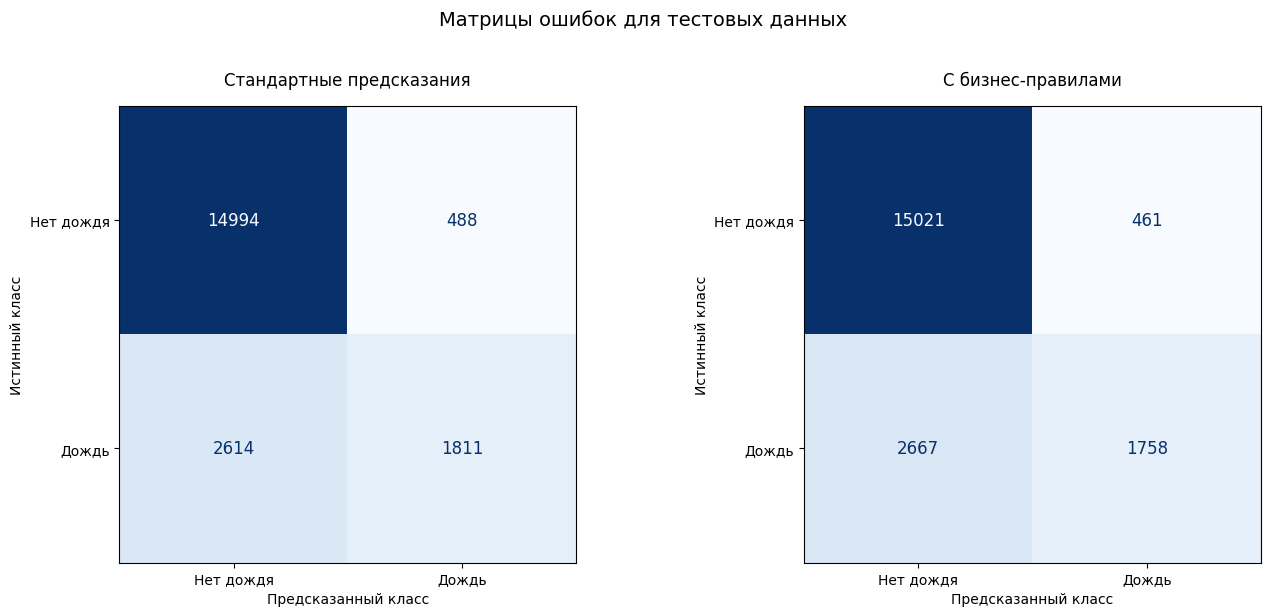


Модель успешно сохранена в rain_predictor_final.joblib

Генерация прогнозов для городов...

ТОП ПРОГНОЗОВ ПОГОДЫ ПО ГОРОДАМ
+------------------+------------+----------+-----------+-----------------------------------------+
|      Город       |    Дата    |  Вер-ть  |  Прогноз  |            Ключевые факторы             |
+==================+============+==========+===========+=========================================+
|     Portland     | 25.06.2017 |   80%    |   Дождь   | Влажность: 83.0%, Осадки 3 дня: 13.6 мм |
+------------------+------------+----------+-----------+-----------------------------------------+
|     Dartmoor     | 25.06.2017 |   68%    |   Дождь   |            Влажность: 89.0%             |
+------------------+------------+----------+-----------+-----------------------------------------+
|    Launceston    | 25.06.2017 |   52%    |   Ясно    |          Осадки 3 дня: 8.6 мм           |
+------------------+------------+----------+-----------+---------------------------

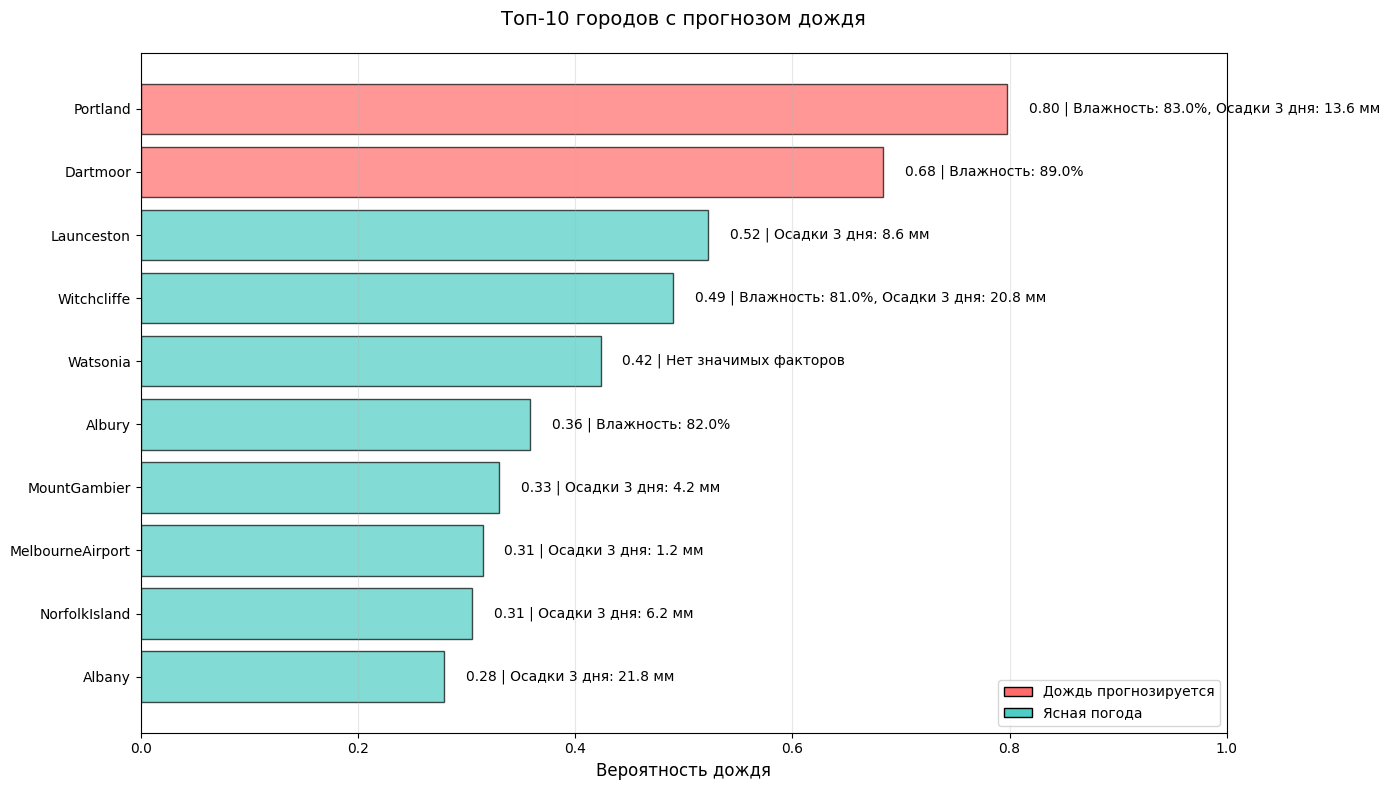

In [78]:
def main():
    try:
        # Обучение и оценка
        model, threshold, metrics = train_and_evaluate()
        
        # Прогноз для городов
        print("\nГенерация прогнозов для городов...")
        data = pd.read_csv(Config.TRAIN_DATA_PATH)
        data, _, _ = preprocess_data(data)
        
        predictions = predict_for_cities(model, data, threshold)
        
        # Вывод результатов
        if not predictions.empty:
            print_city_predictions(predictions)
            visualize_city_predictions(predictions)
        else:
            print("\nНе удалось сгенерировать прогнозы")
        
    except Exception as e:
        print(f"\nОшибка в работе программы: {str(e)}")

if __name__ == "__main__":
    main()